In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
from ste import STE

In [3]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../packages/")
from TsIP.TsIP import TsIP

In [4]:
cols = plt.get_cmap("tab10")

In [5]:
space = {"Rainfall Anomaly": 1, 
         "Rainfall (mm)": 1,
         "Exchange rate": 1,
         "Cereals and tubers": 1,
         "Fatality": 3,
         "NDVI Anomaly": 1,
         "rCSI": 3}

In [6]:
colors = dict()
for i,col in enumerate(space.keys()):
    colors[col] = cols(i)

## Dataset

In [7]:
# Define the country name.
COUNTRY = "Yemen"

In [8]:
PATH_TO_DATA_FOLDER = "../Dataset time-series/data/" + COUNTRY + "/"

In [9]:
# Load the dataset.
df = pd.read_csv(PATH_TO_DATA_FOLDER + "Yemen-day.csv", header = [0, 1], index_col = 0)
df.index.name = "Datetime"
df.index = pd.to_datetime(df.index)
freq = "D"
df.index.freq = freq

In [10]:
# Delete the static features, the features not selected by the experts and the features that we decided to ignore based on correlation analysis.
df.drop(["Ramadan", "Lat", "Lon", "Population", "Code", "3 Months Anomaly (%) Rainfall", "NDVI", "Fuel", "Meat, fish and eggs", "Miscellaneous food", "Oil and fats", "Pulses and nuts", "Vegetables and fruits", "Wage"], axis = 1, level = 1, inplace = True)
df

AdminStrata                        Abyan                                   \
Indicator   1 Month Anomaly (%) Rainfall Cereals and tubers Exchange rate   
Datetime                                                                    
2018-08-22                     90.454758           0.184064      0.207215   
2018-08-23                     89.927580           0.185383      0.210332   
2018-08-24                     89.436780           0.186702      0.213449   
2018-08-25                     88.982357           0.188021      0.216565   
2018-08-26                     88.564312           0.189340      0.219682   
...                                  ...                ...           ...   
2020-08-27                    171.554854           0.501851      0.646330   
2020-08-28                    169.642946           0.504289      0.647670   
2020-08-29                    167.417366           0.506727      0.649010   
2020-08-30                    164.878114           0.509165      0.650351   
2020-08-31                    162.025191           0.511603      0.651691   

AdminStrata                                                            \
Indicator          FCS Fatality NDVI Anomaly Rainfall (mm)       rCSI   
Datetime                                                                
2018-08-22   31.809805     10.0    98.450151       12.9544  37.421880   
2018-08-23   32.374660     10.0    98.353086       13.0949  37.346207   
2018-08-24   33.772110     10.0    98.254291       13.2354  37.999408   
2018-08-25   34.533738     10.0    98.153766       13.3759  36.068234   
2018-08-26   32.327892     10.0    98.051510       13.5164  38.218464   
...                ...      ...          ...           ...        ...   
2020-08-27   41.904470     48.0   145.823773       25.7045  36.319930   
2020-08-28   40.886190     48.0   146.003420       24.3977  36.198210   
2020-08-29   41.594440     48.0   146.162903       23.0909  37.905660   
2020-08-30   41.900450     48.0   146.302223       21.7841  38.521870   
2020-08-31   42.763420     48.0   146.421379       20.4773  38.396000   

AdminStrata                         Aden                     ...  \
Indicator   1 Month Anomaly (%) Rainfall Cereals and tubers  ...   
Datetime                                                     ...   
2018-08-22                    103.239156           0.145709  ...   
2018-08-23                    102.928818           0.148744  ...   
2018-08-24                    102.652003           0.151779  ...   
2018-08-25                    102.408712           0.154814  ...   
2018-08-26                    102.198944           0.157849  ...   
...                                  ...                ...  ...   
2020-08-27                    155.927063           0.504680  ...   
2020-08-28                    154.557280           0.506198  ...   
2020-08-29                    152.978907           0.507716  ...   
2020-08-30                    151.191946           0.509234  ...   
2020-08-31                    149.196396           0.510751  ...   

AdminStrata       Shabwah                                   Taizz  \
Indicator   Rainfall (mm)       rCSI 1 Month Anomaly (%) Rainfall   
Datetime                                                            
2018-08-22        12.5713  34.302200                    93.865658   
2018-08-23        12.8403  36.742499                    94.296436   
2018-08-24        13.1093  35.857748                    94.778817   
2018-08-25        13.3783  34.658434                    95.312802   
2018-08-26        13.6473  35.913080                    95.898390   
...                   ...        ...                          ...   
2020-08-27        26.2283  43.342610                   166.405050   
2020-08-28        24.5661  42.911570                   164.107427   
2020-08-29        22.9039  43.266170                   161.496245   
2020-08-30        21.2417  42.245550                   158.571504   
2020-08-31        19.5795  42.826040            

In [11]:
PROVINCES = df.columns.get_level_values(0).unique()
PROVINCES

Index(['Abyan', 'Aden', 'Al Bayda', 'Al Dhale'e', 'Al Hudaydah', 'Al Jawf',
       'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran', 'Dhamar',
       'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah', 'Sa'ada', 'Sana'a',
       'Shabwah', 'Taizz'],
      dtype='object', name='AdminStrata')

In [12]:
PREDICTORS = df.columns.get_level_values(1).unique()
PREDICTORS

Index(['1 Month Anomaly (%) Rainfall', 'Cereals and tubers', 'Exchange rate',
       'FCS', 'Fatality', 'NDVI Anomaly', 'Rainfall (mm)', 'rCSI'],
      dtype='object', name='Indicator')

# Lag importance

In [13]:
# Select only the endogenous indicators (FCS indicator).
df_fcs = df.xs("FCS", axis = 1, level = 1, drop_level = False)
df_fcs.head()

AdminStrata,Abyan,Aden,Al Bayda,Al Dhale'e,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amanat Al Asimah,Amran,Dhamar,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'ada,Sana'a,Shabwah,Taizz
Indicator,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS
Datetime,,,,,,,,,,,,,,,,,,,,
2018-08-22,31.809805,19.412643,49.318569,38.415584,17.902243,35.067187,18.083183,25.745639,24.075777,36.360875,30.204461,32.363844,41.695435,50.265111,48.752228,51.354731,29.250284,30.901922,33.048813,39.043078
2018-08-23,32.374660,21.149675,51.034483,37.643521,18.287813,32.744186,11.840689,25.433362,25.171302,35.571979,29.365854,32.252939,40.600909,49.943757,48.817673,52.447850,29.930260,31.738683,31.034483,39.371670
2018-08-24,33.772110,25.506867,49.224466,39.629049,19.172334,36.061269,14.884980,26.628819,23.225682,38.183475,30.981888,33.020252,38.797170,48.953202,47.548161,51.786465,31.395349,32.759045,25.936048,36.662083
2018-08-25,34.533738,24.338942,48.076367,40.495283,21.687916,40.400411,16.566265,25.198260,23.574934,39.430147,33.146592,33.111702,38.377358,46.274738,46.073439,51.113811,30.455291,33.138993,28.135259,37.205170
2018-08-26,32.327892,24.294671,48.911223,40.991926,21.371394,35.632689,20.193152,25.808842,24.204882,45.047022,29.529530,32.469268,37.981147,44.569574,41.661668,48.916896,25.828248,33.035913,28.347996,37.025723


In [14]:
# Compute the entropy rate.
lags = 15
def history_length_Y(serie):
    adminstrata = serie.name[0]
    y = list()
    for k in range(lags):
        result = STE.entropy_rate(serie, m = 3, k = k+1, h = 1)
        y.append(result)
        
    return y  

tqdm.pandas()
df_results_Y = df_fcs.progress_apply(history_length_Y)
df_results_Y.index = df_results_Y.index  + 1
df_results_Y.head()

100%|█████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.67it/s]


AdminStrata,Abyan,Aden,Al Bayda,Al Dhale'e,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amanat Al Asimah,Amran,Dhamar,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'ada,Sana'a,Shabwah,Taizz
Indicator,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS
1,2.375640,2.393549,2.407705,2.390215,2.354296,2.386048,2.363248,2.357529,2.379798,2.369505,2.369178,2.380195,2.372713,2.346186,2.383398,2.387714,2.365845,2.411308,2.383539,2.390827
2,2.251448,2.232130,2.259385,2.225209,2.199416,2.244269,2.221131,2.206426,2.252050,2.219007,2.217432,2.208617,2.248224,2.171035,2.192061,2.222228,2.187832,2.278998,2.234741,2.189336
3,2.058216,2.034960,2.074738,2.018137,2.017682,2.056064,2.053640,2.019554,2.056524,2.038770,2.003029,1.963521,2.026248,1.948755,2.013619,2.006739,1.946268,2.075400,2.050942,1.970916
4,1.630622,1.665919,1.659319,1.568202,1.623312,1.616310,1.623758,1.611244,1.647719,1.653759,1.573375,1.552845,1.622179,1.549509,1.598117,1.568606,1.564649,1.681029,1.581600,1.555865
5,1.155450,1.098936,1.039500,1.054932,1.114480,1.050936,1.063712,1.024928,1.131414,1.086362,0.972581,1.091467,1.132297,1.051922,1.056533,1.075552,1.060650,1.047332,1.007673,1.033586


In [22]:
df_results_Y = df_results_Y.diff().dropna()

In [23]:
def plot_quantiles(df, title = None, xaxis = None, yaxis = None, label = None):
    with plt.style.context("default"):
        # Define the subplot figure.
        fig, axs = plt.subplots(figsize = (15, 7))
        value_statistic = df.agg([lambda x: x.quantile(0.25), np.mean, lambda x: x.quantile(0.75)], axis = 1)
        value_statistic.columns = ["lower_quantile", "mean", "upper_quantile"]
        # Plot.
        value_statistic["mean"].plot(style = ".-", label = label, ax = axs, ms = 12, c = "b")
        axs.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                         y2 = value_statistic["upper_quantile"], color = "b", alpha = 0.3)
        # Set attributes of the plot.
        axs.set_title(title)
        axs.legend(loc = "best", prop = {"size": 15})
        axs.set_xlabel(xaxis, fontsize = 15)
        axs.set_ylabel(yaxis, fontsize = 15)
    return fig, axs

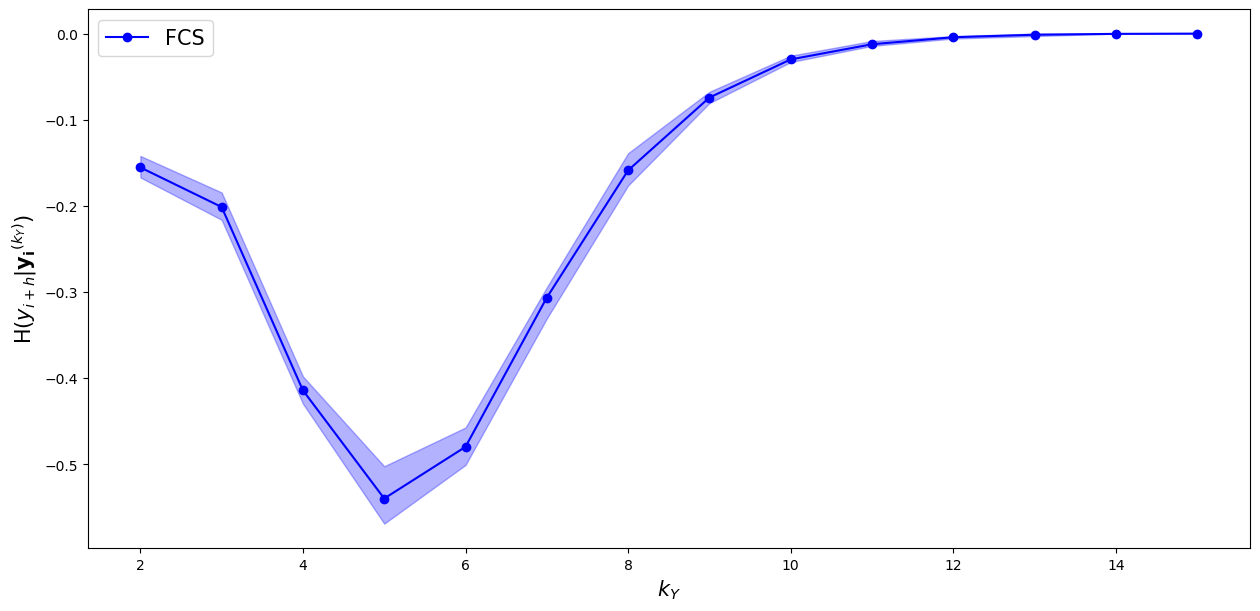

In [24]:
fig, axs = plot_quantiles(df_results_Y, xaxis = "$k_{Y}$", yaxis = "H($y_{i+h}|\mathbf{y_{i}}^{(k_Y)}$)", label = "FCS")

In [15]:
# Select only the exogenous indicators.
df_no_fcs = df.drop(columns = ["FCS"], axis = 1, level = 1)
df_no_fcs.head()

AdminStrata                        Abyan                                   \
Indicator   1 Month Anomaly (%) Rainfall Cereals and tubers Exchange rate   
Datetime                                                                    
2018-08-22                     90.454758           0.184064      0.207215   
2018-08-23                     89.927580           0.185383      0.210332   
2018-08-24                     89.436780           0.186702      0.213449   
2018-08-25                     88.982357           0.188021      0.216565   
2018-08-26                     88.564312           0.189340      0.219682   

AdminStrata                                                 \
Indicator   Fatality NDVI Anomaly Rainfall (mm)       rCSI   
Datetime                                                     
2018-08-22      10.0    98.450151       12.9544  37.421880   
2018-08-23      10.0    98.353086       13.0949  37.346207   
2018-08-24      10.0    98.254291       13.2354  37.999408   
2018-08-25      10.0    98.153766       13.3759  36.068234   
2018-08-26      10.0    98.051510       13.5164  38.218464   

AdminStrata                         Aden                                   \
Indicator   1 Month Anomaly (%) Rainfall Cereals and tubers Exchange rate   
Datetime                                                                    
2018-08-22                    103.239156           0.145709      0.196182   
2018-08-23                    102.928818           0.148744      0.199236   
2018-08-24                    102.652003           0.151779      0.202291   
2018-08-25                    102.408712           0.154814      0.205345   
2018-08-26                    102.198944           0.157849      0.208400   

AdminStrata  ...      Shabwah                           \
Indicator    ... NDVI Anomaly Rainfall (mm)       rCSI   
Datetime     ...                                         
2018-08-22   ...    99.411750       12.5713  34.302200   
2018-08-23   ...    99.381895       12.8403  36.742499   
2018-08-24   ...    99.351971       13.1093  35.857748   
2018-08-25   ...    99.321979       13.3783  34.658434   
2018-08-26   ...    99.291919       13.6473  35.913080   

AdminStrata                        Taizz                                   \
Indicator   1 Month Anomaly (%) Rainfall Cereals and tubers Exchange rate   
Datetime                                                                    
2018-08-22                     93.865658           0.200933      0.207371   
2018-08-23                     94.296436           0.201173      0.210846   
2018-08-24                     94.778817           0.201412      0.214321   
2018-08-25                     95.312802           0.201651      0.217796   
2018-08-26                     95.898390           0.201891      0.221272   

AdminStrata                                                 
Indicator   Fatality NDVI Anomaly Rainfall (mm)       rCSI  
Datetime                                                    
2018-08-22     171.0   104.340193       41.6606  50.919038  
2018-08-23     147.0   104.184601       42.6437  50.415852  
2018-08-24     145.0   104.021750       43.6268  49.391298  
2018-08-25     156.0   103.851638       44.6099  50.302392  
2018-08-26     164.0   103.674267       45.5930  50.293046  

[5 rows x 140 columns]

In [16]:
lags = 15

In [68]:
def history_length_X(serie):
    adminstrata = serie.name[0]
    indicator = serie.name[1]
    y = list()
    for k in range(lags):
        result = STE.calc_ste(serie, df_fcs[adminstrata]["FCS"], m = 3, kx = k+1, ky = 1, h = 1)
        y.append(result)        
    return y  

tqdm.pandas()
df_results_X = df_no_fcs.progress_apply(history_length_X)
df_results_X.head()







  0%|                                                                 | 0/140 [00:00<?, ?it/s]





  1%|▊                                                        | 2/140 [00:01<01:12,  1.91it/s]





  2%|█▏                                                       | 3/140 [00:01<01:27,  1.56it/s]





  3%|█▋                                                       | 4/140 [00:02<01:29,  1.52it/s]





  4%|██                                                       | 5/140 [00:04<02:17,  1.02s/it]





  4%|██▍                                                      | 6/140 [00:05<02:12,  1.01it/s]





  5%|██▊                                                      | 7/140 [00:06<02:30,  1.13s/it]





  6%|███▎                                                     | 8/140 [00:09<03:39,  1.66s/it]





  6%|███▋                                                     | 9/140 [00:10<03:11,  1.46s/it]





  7%|████                                                    | 10/140 [00:11<02:53,  1.33s/it]

 99%|██████████████████████████████████████████████████████▌| 139/140 [03:19<00:01,  1.56s/it]





100%|███████████████████████████████████████████████████████| 140/140 [03:23<00:00,  1.45s/it]


AdminStrata                        Abyan                                   \
Indicator   1 Month Anomaly (%) Rainfall Cereals and tubers Exchange rate   
0                               0.036983           0.029513      0.022166   
1                               0.063843           0.043434      0.033856   
2                               0.092009           0.057987      0.050759   
3                               0.116878           0.074486      0.060372   
4                               0.145934           0.100275      0.072311   

AdminStrata                                                 \
Indicator    Fatality NDVI Anomaly Rainfall (mm)      rCSI   
0            0.050897     0.018642      0.038054  0.058041   
1            0.119110     0.031845      0.086624  0.217705   
2            0.242464     0.044301      0.121915  0.502128   
3            0.322452     0.054843      0.169276  0.845614   
4            0.390930     0.064362      0.207496  1.147523   

AdminStrata                         Aden                                   \
Indicator   1 Month Anomaly (%) Rainfall Cereals and tubers Exchange rate   
0                               0.032343           0.034943      0.016432   
1                               0.064134           0.053211      0.032626   
2                               0.092600           0.065447      0.050408   
3                               0.115747           0.085158      0.064448   
4                               0.140745           0.111468      0.082776   

AdminStrata  ...      Shabwah                          \
Indicator    ... NDVI Anomaly Rainfall (mm)      rCSI   
0            ...     0.017741      0.030096  0.065276   
1            ...     0.032281      0.054756  0.222724   
2            ...     0.048943      0.084957  0.534780   
3            ...     0.065761      0.127672  0.903977   
4            ...     0.080298      0.156674  1.162289   

AdminStrata                        Taizz                                   \
Indicator   1 Month Anomaly (%) Rainfall Cereals and tubers Exchange rate   
0                               0.039987           0.042057      0.026136   
1                               0.075950           0.068369      0.043105   
2                               0.108404           0.088171      0.062620   
3                               0.146060           0.115308      0.077678   
4                               0.180937           0.137304      0.090061   

AdminStrata                                                 
Indicator    Fatality NDVI Anomaly Rainfall (mm)      rCSI  
0            0.043081     0.037641      0.043960  0.072916  
1            0.203795     0.062758      0.079561  0.236395  
2            0.451518     0.086232      0.115774  0.535829  
3            0.755379     0.114081      0.154791  0.901966  
4            1.000320     0.133113      0.198761  1.166463  

[5 rows x 140 columns]

In [69]:
df_results_X = df_results_X.diff().dropna()

In [70]:
df_results_X.rename({"1 Month Anomaly (%) Rainfall": "Rainfall Anomaly"}, axis = 1, level = 1, inplace = True)

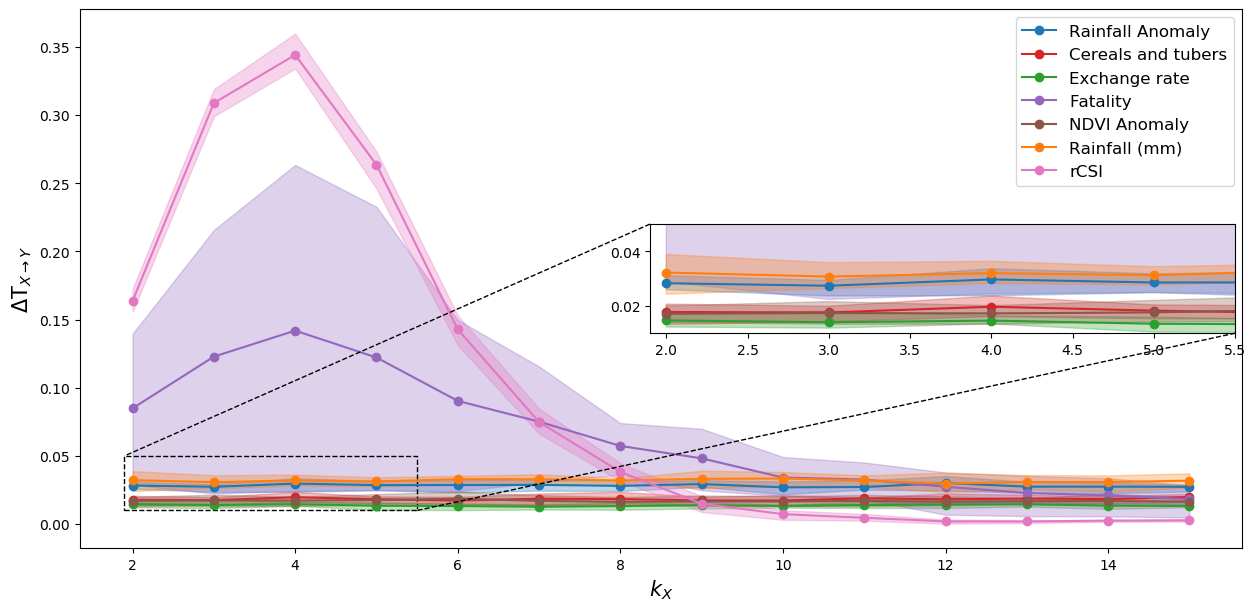

In [80]:
with plt.style.context("default"):
    # Define the subplot figure.
    fig, axs = plt.subplots(figsize = (15, 7))
    axins = zoomed_inset_axes(axs, 2., loc = "right")
    for i,indicator in enumerate(df_results_X.columns.get_level_values(1).unique()):
        subdf = df_results_X.xs(indicator, axis = 1, level = 1, drop_level = False)
        subdf.index = subdf.index + 1
        value_statistic = subdf.agg([lambda x: x.quantile(0.25), np.mean, lambda x: x.quantile(0.75)], axis = 1)
        value_statistic.columns = ["lower_quantile", "mean", "upper_quantile"]
        # Plot.
        value_statistic["mean"].plot(style = ".-", label = indicator, ax = axs, ms = 12, c = colors[indicator])
        value_statistic["mean"].plot(style = ".-", label = indicator, ax = axins, ms = 12, c = colors[indicator])
        axs.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                         y2 = value_statistic["upper_quantile"], color = colors[indicator], alpha = 0.3)
        axins.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                           y2 = value_statistic["upper_quantile"], color = colors[indicator], alpha = 0.3)
        # Set attributes of the plot.
        axs.legend(loc = "best", prop = {"size": 12})
        axs.set_xlabel("$k_{X}$", fontsize = 15)
        axs.set_ylabel(r'$\Delta$T$_{X \rightarrow Y}$', fontsize = 15)

    axins.set_xlim(1.9, 5.5)
    axins.set_ylim(0.01, 0.05)
    mark_inset(axs, axins, loc1 = 2, loc2 = 4, fc = "none", ec = "black", linestyle  = "--")
    # Save the figure.
    fig.savefig("Lags.png", bbox_inches = "tight", dpi = 300)

# Feature importance

In [21]:
df_feature_importance = df.copy()
df_feature_importance.head()

AdminStrata                        Abyan                                   \
Indicator   1 Month Anomaly (%) Rainfall Cereals and tubers Exchange rate   
Datetime                                                                    
2018-08-22                     90.454758           0.184064      0.207215   
2018-08-23                     89.927580           0.185383      0.210332   
2018-08-24                     89.436780           0.186702      0.213449   
2018-08-25                     88.982357           0.188021      0.216565   
2018-08-26                     88.564312           0.189340      0.219682   

AdminStrata                                                            \
Indicator          FCS Fatality NDVI Anomaly Rainfall (mm)       rCSI   
Datetime                                                                
2018-08-22   31.809805     10.0    98.450151       12.9544  37.421880   
2018-08-23   32.374660     10.0    98.353086       13.0949  37.346207   
2018-08-24   33.772110     10.0    98.254291       13.2354  37.999408   
2018-08-25   34.533738     10.0    98.153766       13.3759  36.068234   
2018-08-26   32.327892     10.0    98.051510       13.5164  38.218464   

AdminStrata                         Aden                     ...  \
Indicator   1 Month Anomaly (%) Rainfall Cereals and tubers  ...   
Datetime                                                     ...   
2018-08-22                    103.239156           0.145709  ...   
2018-08-23                    102.928818           0.148744  ...   
2018-08-24                    102.652003           0.151779  ...   
2018-08-25                    102.408712           0.154814  ...   
2018-08-26                    102.198944           0.157849  ...   

AdminStrata       Shabwah                                   Taizz  \
Indicator   Rainfall (mm)       rCSI 1 Month Anomaly (%) Rainfall   
Datetime                                                            
2018-08-22        12.5713  34.302200                    93.865658   
2018-08-23        12.8403  36.742499                    94.296436   
2018-08-24        13.1093  35.857748                    94.778817   
2018-08-25        13.3783  34.658434                    95.312802   
2018-08-26        13.6473  35.913080                    95.898390   

AdminStrata                                                                    \
Indicator   Cereals and tubers Exchange rate        FCS Fatality NDVI Anomaly   
Datetime                                                                        
2018-08-22            0.200933      0.207371  39.043078    171.0   104.340193   
2018-08-23            0.201173      0.210846  39.371670    147.0   104.184601   
2018-08-24            0.201412      0.214321  36.662083    145.0   104.021750   
2018-08-25            0.201651      0.217796  37.205170    156.0   103.851638   
2018-08-26            0.201891      0.221272  37.025723    164.0   103.674267   

AdminStrata                           
Indicator   Rainfall (mm)       rCSI  
Datetime                              
2018-08-22        41.6606  50.919038  
2018-08-23        42.6437  50.415852  
2018-08-24        43.6268  49.391298  
2018-08-25        44.6099  50.302392  
2018-08-26        45.5930  50.293046  

[5 rows x 160 columns]

In [22]:
space = {"1 Month Anomaly (%) Rainfall": 1, 
         "Rainfall (mm)": 1,
         "Exchange rate": 1,
         "Cereals and tubers": 1,
         "Fatality": 3,
         "NDVI Anomaly": 1,
         "rCSI": 3}

In [31]:
rows_ste = list()
rows_ste_rank = list()

def feature_importance(group):
    adminstrata = group.name
    rows = dict()
    for indicator in space.keys():
        result = STE.calc_ste(group[adminstrata][indicator], df_fcs[adminstrata]["FCS"], m = 3, kx = 1, ky = 1, h = 1)
        rows[indicator] = result
    row = pd.Series(rows)
    row.name = adminstrata + " - FCS"
    rows_ste.append(row)
    rows_ste_rank.append(row.rank(method = "max", ascending = False))

tqdm.pandas()
df_feature_importance.groupby(level = 0, axis = 1).progress_apply(feature_importance);
T_fcs = pd.concat(rows_ste, axis = 1).transpose()
T_fcs_rank = pd.concat(rows_ste_rank, axis = 1).transpose()






  0%|                                                                  | 0/20 [00:00<?, ?it/s]




 10%|█████▊                                                    | 2/20 [00:00<00:02,  7.63it/s]




 15%|████████▋                                                 | 3/20 [00:00<00:03,  5.57it/s]




 20%|███████████▌                                              | 4/20 [00:00<00:03,  4.75it/s]




 25%|██████████████▌                                           | 5/20 [00:01<00:03,  4.16it/s]




 30%|█████████████████▍                                        | 6/20 [00:01<00:03,  3.90it/s]




 35%|████████████████████▎                                     | 7/20 [00:01<00:03,  3.79it/s]




 40%|███████████████████████▏                                  | 8/20 [00:01<00:03,  3.77it/s]




 45%|██████████████████████████                                | 9/20 [00:02<00:03,  3.64it/s]




 50%|████████████████████████████▌                            | 10/20 [00:02<00:02,  3.60it/s]




 55%|

In [42]:
T_fcs.rename({"1 Month Anomaly (%) Rainfall": "Rainfall Anomaly"}, axis = 1, inplace = True)

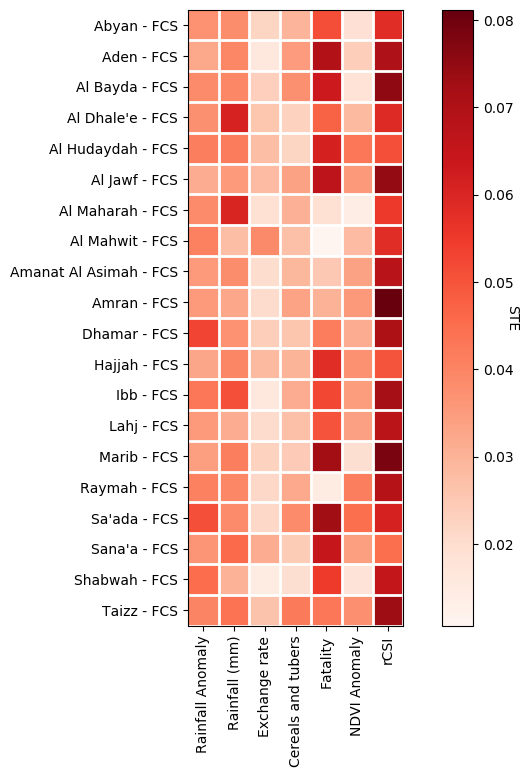

In [43]:
with plt.style.context("default"):
    fig, ax = plt.subplots(figsize = (10, 8))
    im = ax.imshow(T_fcs.astype(float), cmap = "Reds")
    cbar = fig.colorbar(im, ax = ax)
    #clb = plt.colorbar()
    cbar.set_label("STE", rotation = 270)

    ax.set_xticks(range(len(T_fcs.columns)))
    ax.set_yticks(range(len(T_fcs.index)))
    ax.set_xticklabels(T_fcs.columns, rotation = 90)
    ax.set_yticklabels(T_fcs.index)
    #ax.set_xlabel("Indicator")
    #ax.set_ylabel("AdminStrata")
    #ax.set_title("T - Influence different indicators for FCS")
    for i in range(T_fcs.shape[0]):
        ax.axhline(i + 0.5, color = "white", lw = 2)
    for i in range(T_fcs.shape[1]):
        ax.axvline(i + 0.5, color = "white", lw = 2)
        
    # Save the figure.
    fig.savefig("importance.png", bbox_inches = "tight", dpi = 300)

In [40]:
T_fcs_rank.rename({"1 Month Anomaly (%) Rainfall": "Rainfall Anomaly"}, axis = 1, inplace = True)

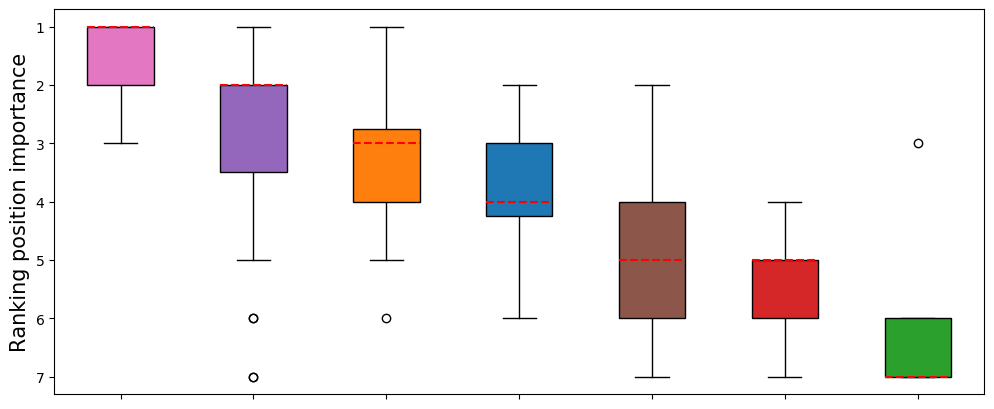

In [92]:
with plt.style.context("default"):
    fig, ax = plt.subplots(figsize = (12, 5))
    T_fcs_rank = T_fcs_rank.astype(int)
    meds = T_fcs_rank.mean()
    meds.sort_values(ascending = True, inplace = True)
    T_fcs_rank_sort = T_fcs_rank[meds.index]
    #cm = plt.cm.get_cmap("tab20")
    #colors = [cm(val/len(T_fcs_rank_sort.columns)) for val in range(len(T_fcs_rank_sort.columns))]
    bplot = ax.boxplot(T_fcs_rank_sort.T, patch_artist = True, medianprops = {"linestyle": "--", "linewidth": 1.5, "color": "red"}) 
    # Fill with colors.
    for patch, color in zip(bplot["boxes"], T_fcs_rank_sort.columns):
        patch.set_facecolor(colors[color])
    
    ax.invert_yaxis()
    #ax.set_xlabel("Indicator")
    ax.set_ylabel("Ranking position importance", fontsize = 15)
    
    ax.set_xticklabels([""]*len(T_fcs_rank_sort.columns), rotation = 0, fontsize = 15)  
    
    # Save the figure.
    fig.savefig("ranking.png", bbox_inches = "tight", dpi = 300)